In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.models.np import NeuralProcess
from activephasemap.utils.settings import initialize_model
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.settings import from_comp_to_spectrum, get_twod_grid
from botorch.utils.sampling import draw_sobol_samples

import json 

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [3]:
ITERATION = 7
DATA_DIR = "./"
design_space_bounds = [(0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0), 
                       (0.0, 11.0),
                       ]

expt = UVVisExperiment(design_space_bounds, ITERATION, DATA_DIR+"/data/")
expt.generate(use_spline=True)
gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
np_model_args = {"num_iterations": 1, "verbose":True, "print_freq":100, "lr":5e-4}
input_dim = expt.dim

with open('../best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

# Load trained GP model for p(z|c)
train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
bounds = expt.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_model = initialize_model(normalized_x, train_y, gp_model_args, input_dim, N_LATENT, device)
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
gp_model.load_state_dict(gp_state_dict)

# Load trained NP model for p(y|z)
np_model = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(ITERATION), map_location=device))

Loading data from iteration 0 with shapes: (72, 5) (72, 101)
Loading data from iteration 1 with shapes: (87, 5) (87, 101)
Loading data from iteration 2 with shapes: (86, 5) (86, 101)
Loading data from iteration 3 with shapes: (84, 5) (84, 101)
Loading data from iteration 4 with shapes: (87, 5) (87, 101)
Loading data from iteration 5 with shapes: (87, 5) (87, 101)
Loading data from iteration 6 with shapes: (87, 5) (87, 101)


<All keys matched successfully>

### Plot few samples from Nueral Process Model

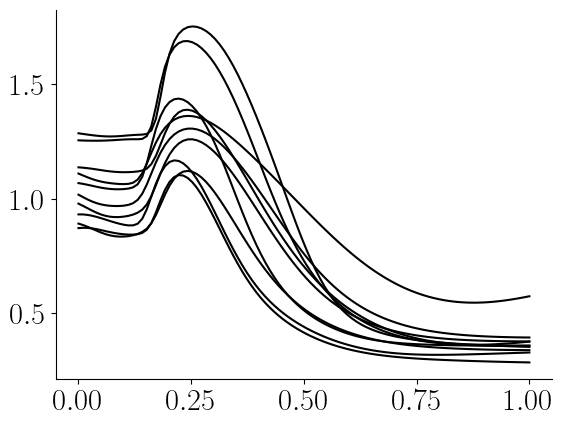

In [4]:
x_target = torch.Tensor(np.linspace(0, 1, 100)).to(device)
x_target = x_target.unsqueeze(1).unsqueeze(0)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    z_sample = torch.randn((10, N_LATENT)).to(device)
    for i in range(10):
        mu, _ = np_model.xz_to_y(x_target, z_sample[i,:])
        ax.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], color='k')
    plt.show()

### Plot random sample from GP model 

We randomly sample few points on the composition space and use it produce sampled curves from the composite model

/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


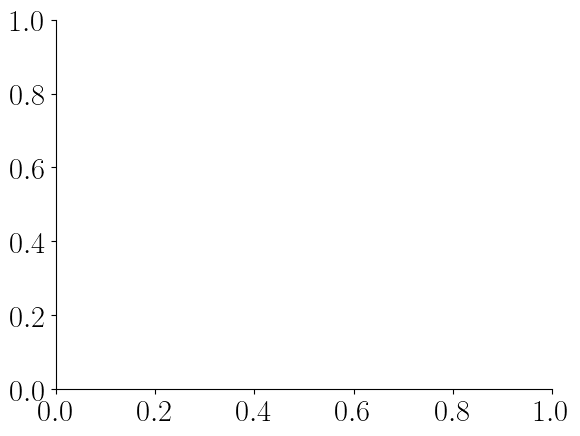

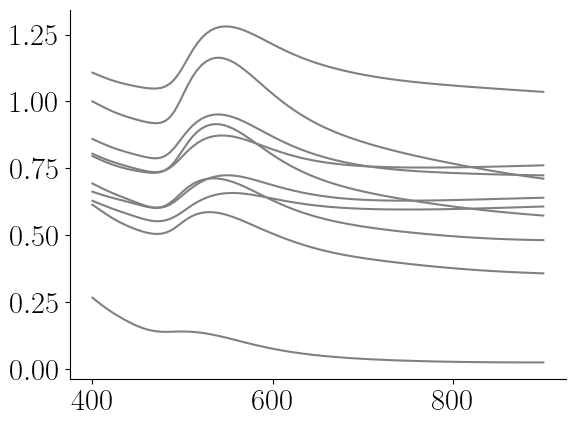

In [14]:
with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots()

    samples = draw_sobol_samples(bounds=bounds, n=10, q=1).squeeze().numpy()
    for c in samples:
        mu, _ = from_comp_to_spectrum(expt, 
                                      gp_model, 
                                      np_model, 
                                      c.reshape(1, expt.dim)
                                      )
        mu_ = mu.cpu().squeeze()
        ax.plot(expt.wl, mu_, label="GP pred.", color="grey")
    plt.show()